In [ ]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
except ImportError:
    pass

In [ ]:
import h5py
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, roc_auc_score, roc_curve, precision_score, recall_score
import tqdm, torch
from torch.autograd import Variable
from torch.nn import Sigmoid, Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

In [ ]:
# Path to your HDF5 file
hdf5_file_path = '/content/drive/My Drive/IS4242/processed_data/preprocessed_images_h5'
# hdf5_file_path = './preprocessed_images_h5'

# Open the HDF5 file
with h5py.File(hdf5_file_path, 'r') as hf:
    # Access the dataset containing images
    images = hf['preprocessed_images'][:]

# Now 'images' variable contains your array of images
# You can use it as needed
print(f"Loaded HDF5 file with images of shape: {images.shape}")

Loaded HDF5 file with images of shape: (857, 128, 128, 3)


In [ ]:
# Path to your HDF5 file
hdf5_file_path = '/content/drive/My Drive/IS4242/processed_data/labels_h5'
# hdf5_file_path = './labels_h5'

# Open the HDF5 file
with h5py.File(hdf5_file_path, 'r') as hf:
    # Access the dataset containing images
    labels = hf['labels'][:]

# Now 'images' variable contains your array of images
# You can use it as needed
print(f"Loaded HDF5 file with labels of shape: {labels.shape}")

Loaded HDF5 file with labels of shape: (857,)


In [ ]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
#X_train, X_val, y_train, y_val=train_test_split(X_train, y_train, test_size=0.2)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(685, 128, 128, 3)
(172, 128, 128, 3)
(685,)
(172,)


In [ ]:
label_dict = {'France grn':0, 'Fuji':1, 'USA Envy':2, 'USA Koru':3}
y_train_decode = [label.decode() for label in y_train]
y_test_decode = [label.decode() for label in y_test]
y_train_decode = np.array([label_dict[label] for label in y_train_decode])
y_test_decode = np.array([label_dict[label] for label in y_test_decode])
print(np.unique(y_train_decode))

[0 1 2 3]


In [ ]:
X_train, X_test = torch.tensor(X_train, dtype=torch.float32), torch.tensor(X_test, dtype=torch.float32)
y_train, y_test = torch.tensor(y_train_decode, dtype=torch.long), torch.tensor(y_test_decode, dtype=torch.long)

In [ ]:
# CNN Model
# Reference: https://www.analyticsvidhya.com/blog/2019/10/building-image-classification-models-cnn-pytorch/
class Net(Module):
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(128, 20, kernel_size=2, stride=1, padding=1),
            BatchNorm2d(20),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer
            Conv2d(20, 4, kernel_size=2, stride=1, padding=1),
            BatchNorm2d(4),
            Sigmoid(),
            MaxPool2d(kernel_size=2, stride=2),
        )

        self.linear_layers = Sequential(
            Linear(128, 4)
        )

    # Defining the forward pass
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

model = Net()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.01) #torch.optim.SGD(model.parameters(), lr=0.04)
# defining the loss function
loss_fn = CrossEntropyLoss()

model.to(device)

print(model)

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(128, 20, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(20, 4, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Sigmoid()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=128, out_features=4, bias=True)
  )
)


In [ ]:
# Training model
def train_model(model, optimizer, train_data, train_label, loss_func, num_epochs=500):
    model.train()

    for epoch in tqdm.tqdm(range(num_epochs)):
        train_data = train_data.to(device)
        train_label = train_label.to(device)

        preds = model(train_data)
        loss = loss_func(preds, train_label)

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}")

train_model(model, optimizer, X_train, y_train, loss_fn)

  0%|          | 1/500 [00:00<07:55,  1.05it/s]

Epoch 0, Loss: 1.526284098625183


 20%|██        | 101/500 [01:09<04:40,  1.42it/s]

Epoch 100, Loss: 0.28673651814460754


 40%|████      | 201/500 [02:16<03:13,  1.55it/s]

Epoch 200, Loss: 0.07996786385774612


 60%|██████    | 301/500 [03:24<02:14,  1.48it/s]

Epoch 300, Loss: 0.017633555456995964


 80%|████████  | 401/500 [04:32<01:08,  1.45it/s]

Epoch 400, Loss: 0.006938471458852291


100%|██████████| 500/500 [05:39<00:00,  1.47it/s]


In [ ]:
# prediction for training set
model.eval()
with torch.no_grad():
    output_train = model(X_train)

prob_train = torch.exp(output_train).numpy()
preds_train = np.argmax(prob_train, axis=1)

# prediction for testing set
with torch.no_grad():
    output_test = model(X_test)

prob_test = torch.exp(output_test).numpy()
preds_test = np.argmax(prob_test, axis=1)

print("Training Accuracy:", accuracy_score(y_train, preds_train))
print("Testing Accuracy:", accuracy_score(y_test, preds_test))

Training Accuracy: 1.0
Testing Accuracy: 0.8837209302325582


In [ ]:
print(classification_report(y_test, preds_test))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98        27
           1       0.91      0.96      0.94        54
           2       0.86      0.86      0.86        59
           3       0.77      0.72      0.74        32

    accuracy                           0.88       172
   macro avg       0.89      0.88      0.88       172
weighted avg       0.88      0.88      0.88       172



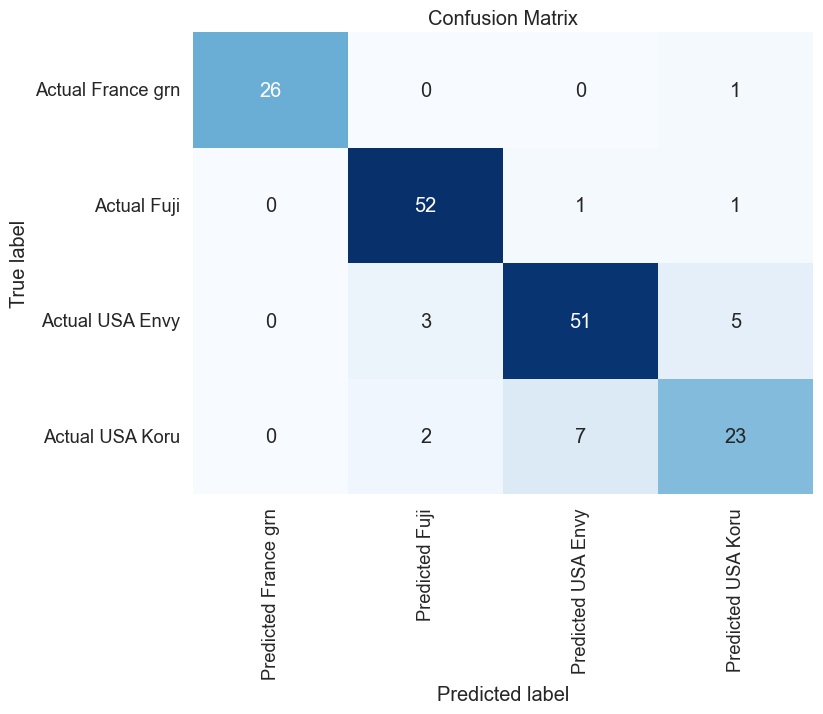

In [ ]:
conf_matrix = confusion_matrix(y_test, preds_test)
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False,
            xticklabels=['Predicted France grn', 'Predicted Fuji', 'Predicted USA Envy', 'Predicted USA Koru'],
            yticklabels=['Actual France grn', 'Actual Fuji', 'Actual USA Envy', 'Actual USA Koru'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

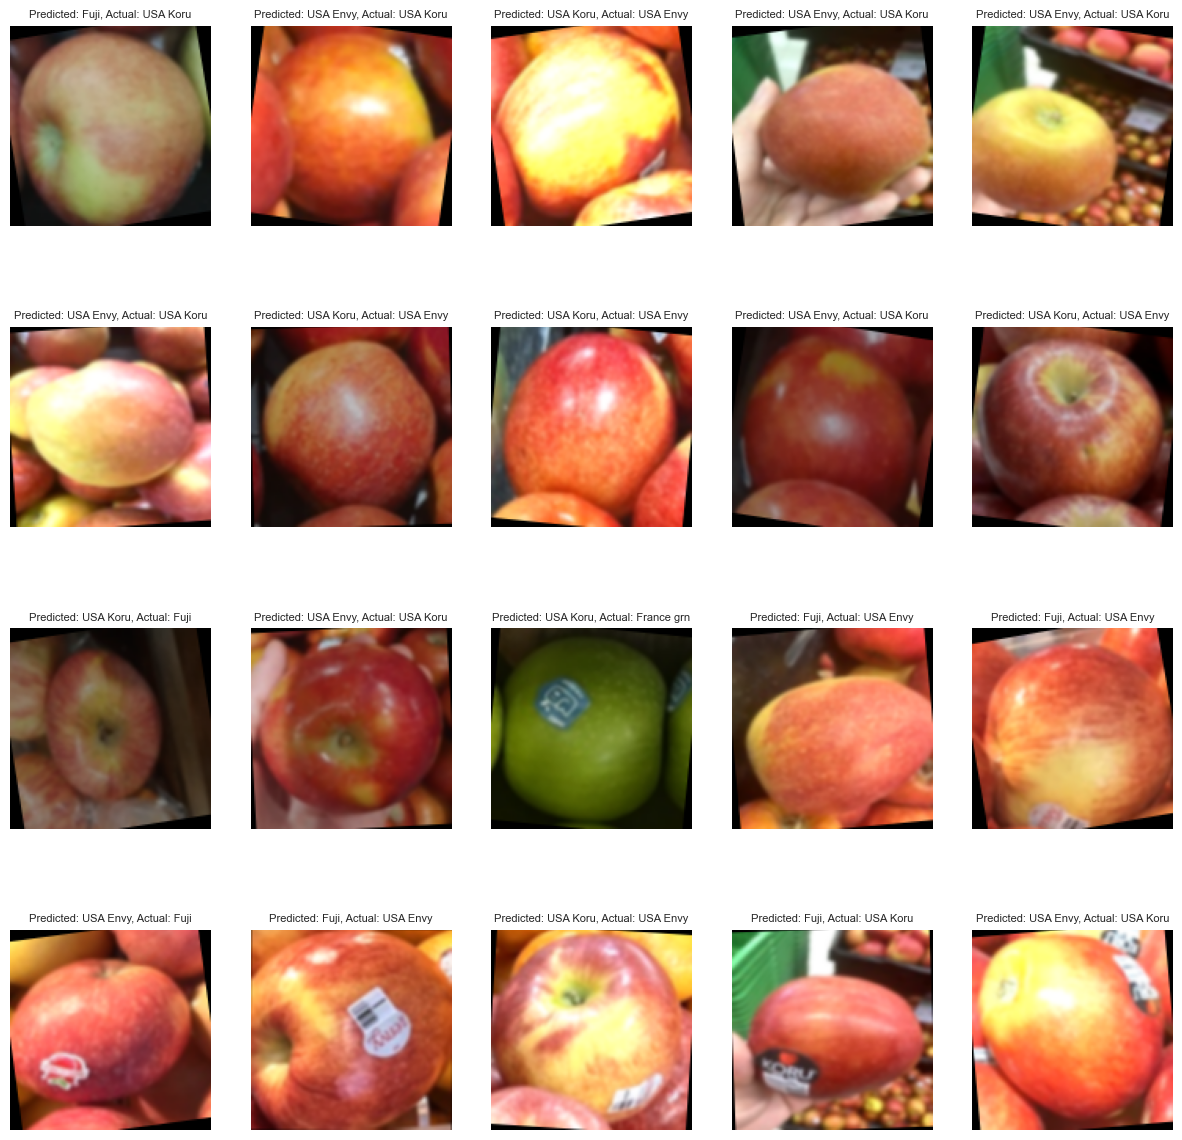

In [ ]:
misclassified_indices = np.where(y_test.numpy() != preds_test)[0]
apples = list(label_dict.keys())

# Output the wrongly classified images
plt.figure(figsize=(15, 15))
for i, index in enumerate(misclassified_indices[:len(misclassified_indices)]):
    plt.subplot(4, 5, i + 1)
    plt.imshow(X_test.numpy()[index][:,:,::-1])
    plt.title(f'Predicted: {apples[preds_test[index]]}, Actual: {apples[y_test[index]]}', fontdict={'fontsize': 8})
    plt.axis('off')
plt.show()